# Spectral Clustering

### Pros:
- Can handle clusters with complex geometries, with varying shapes (vs k-means, hierarchical clustering (non single/complete/average linkage methods struggle with non elliptical shapes, but single linkage methods are prone to "chaining")), sizes (vs hierarchical clustering), and densities (vs DBSCAN)

### Cons:
- Sensitive to choice of connectivity parameters and similarity function: fully connected graph (sigma),
epsilon-neighborhood (epsilon), k-nn (k)
- Sensitivity to choice of number of clusters
- Sensitive to outliers/noise
- Computing eigenvalues and vectors of Lapacian can be expensive 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

In [2]:
def similarity_graph_fc(X, sigma):
    """
    To produce fully connected similarity graph
    Adjacency matrix : W[i,j]= weight of edge between nodes i and j (0 if i=j)
    Using the gaussian radial basis similarity function (RBF)

    sigma : parameter that controls the width of the neighborhood around each point
    """

    W = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                W[i, j] = np.exp(-np.sum((X[i] - X[j])**2) / (2 * sigma**2))
    return W

In [40]:
def similarity_graph_knn(X, k):
    """ 
    Similarity graph using k-nearest neighbors
    Adjacency matrix: W[i, j] = 1 if nodes i and j are k-nearest neighbors, else 0
    """
    # Number of data points
    n_samples = X.shape[0]

    # Initialize the adjacency matrix
    W = np.zeros((n_samples, n_samples))

    # Find the k-nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Construct the similarity graph
    for i in range(n_samples):
        for j in range(1, k+1):  # start from 1 to exclude the point itself
            neighbor_idx = indices[i, j]
            W[i, neighbor_idx] = 1
            W[neighbor_idx, i] = 1  # ensure the matrix is symmetric

    return W

In [52]:
def similarity_graph_eps(X, epsilon):
    """ 
    Similarity graph using epsilon-neighborhood
    Adjacency matrix: W[i, j] = 1 if the distance between nodes i and j is less than epsilon, else 0
    """

    # Compute the pairwise distance matrix
    dist_matrix = pairwise_distances(X)

    # Initialize the adjacency matrix
    W = np.zeros_like(dist_matrix)

    # Apply epsilon threshold
    W[dist_matrix < epsilon] = 1
    np.fill_diagonal(W, 0)  # Ensure no self-loops

    return W


In [4]:
def degree_matrix(W):

    """ 
    Degree matrix : diagonal matrix whose diagonal elements correspond to the sum of the weights of the edges 
    connected to each node in the graph
    D[i,i] = sum of weights of edges of node i
    """

    D = np.zeros_like(W)
    for i in range(len(W)):
        D[i, i] = np.sum(W[i])
    return D

In [46]:
def laplacian(W,D,type):
    """
    The diagonal entries of the Laplacian are the degrees of the nodes, and its off-diagonal entries 
    are the negatives of the edge weights
    """
    # Compute the unnormalized Laplacian
    L = D - W
    
    # Compute D^(-1/2)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    
    # Compute the symmetric normalized Laplacian
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt

    # Compute D^(-1)
    D_inv = np.diag(1.0 / np.diag(D))
    
    # Compute the random walk normalized Laplacian
    L_rw = D_inv @ L

    if type == "unnormed":
        return L
    elif type == "sym_norm":
        return L_sym
    elif type == "rw_norm":
        return L_rw
    else:
        print("Type not recognized.")

In [92]:
def first_k_eigenvectors(L, k_vect, normalization):
    """ 
    Compute the eigenvectors of the Lapacian
    (Choose the first k eigenvectors, where k = number of vecs associated with 
    zero eigenvalue (nbr of connected components) + 2 )
    Let U in R^(n x k) be the matrix whose columns are the eigenvectors
    """
    # Compute the first k smallest eigenvalues and corresponding eigenvectors
    eigenvalues, eigenvectors = eigsh(L, k=k_vect, which='SM')
                                      #np.linalg.eig(L)
    
    #num_zeros = np.sum(np.round(eigenvalues, 3)== 0)

    #k_vect = num_zeros +2

    #U = eigenvectors[:, :k_vect]
    U = eigenvectors

    # Compute the row-wise Euclidean norm
    row_norms = np.linalg.norm(U, axis=1, keepdims=True)
    
    # Normalize each element in U by dividing by the row norm
    T = U / row_norms
    
    if normalization == False:
        return U
    else:
        return T


In [ ]:
def kmeans_clustering(X, U, k):
    """
    Perform k-means clustering on the rows of U 
    
    """
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(U)
    
    # Form clusters A1, ..., Ak
    clusters = [set() for _ in range(k)]
    # Populate clusters with points from X
    for point_idx, label in enumerate(labels):
        clusters[label].add(tuple(X[point_idx]))

    return clusters, labels

In [ ]:
def plot_clusters_3d(X, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    #colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xyz = X[class_member_mask]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=col, label=f'Cluster {k+1}', s=10, alpha=0.6, edgecolors='w')

    ax.set_title('Spectral Clustering (3D)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

In [93]:
def spectral_clustering(X, graph_type, sigma, epsilon, k, laplacian_type, k_vect, plot):

    if graph_type == "fc":
        W = similarity_graph_fc(X, sigma)
    elif graph_type == "knn":
        W = similarity_graph_knn(X, k)
    elif graph_type == "eps":
        W = similarity_graph_eps(X, epsilon)
    else:
        print("Similarity graph type not recognized.")

    D = degree_matrix(W)

    L = laplacian(W,D,laplacian_type)
    normalization = bool

    if laplacian_type == "sym_norm":
        normalization == True
    else:
        normalization == False

    U = first_k_eigenvectors(L, k_vect, normalization)

    clusters, labels = kmeans_clustering(X, U, k_vect)

    # Plot the clusters if plot=True
    if plot:
        plot_clusters_3d(X, labels)

    return clusters

## Test on Bedretto M0 dataset

In [ ]:
# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]
X = catalog_xyz.to_numpy()

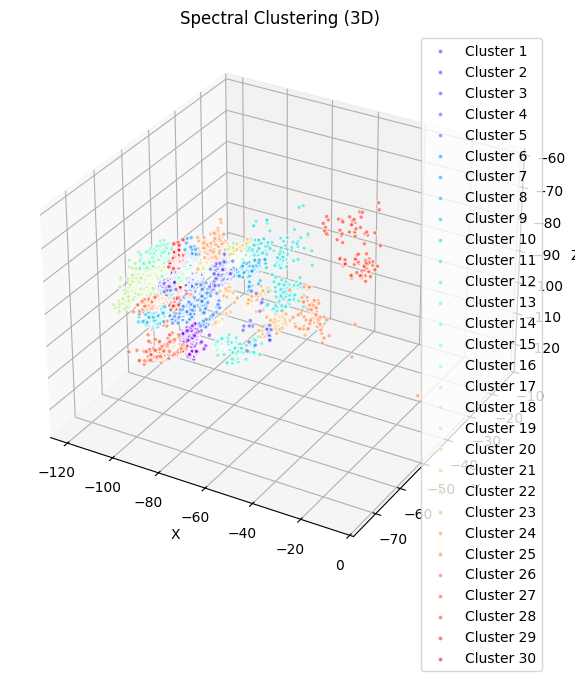

In [94]:
cluster_test = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=10, laplacian_type="rw_norm", k_vect = 30, plot=True)

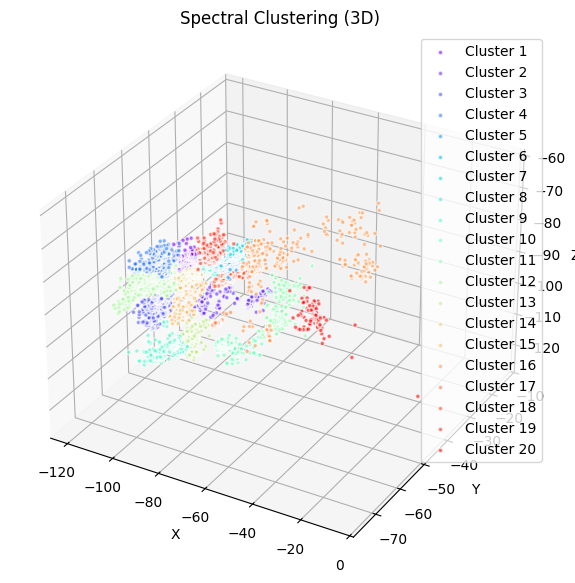

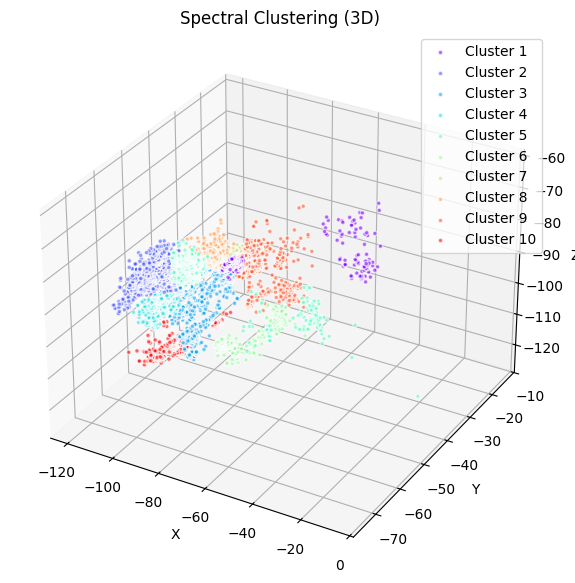

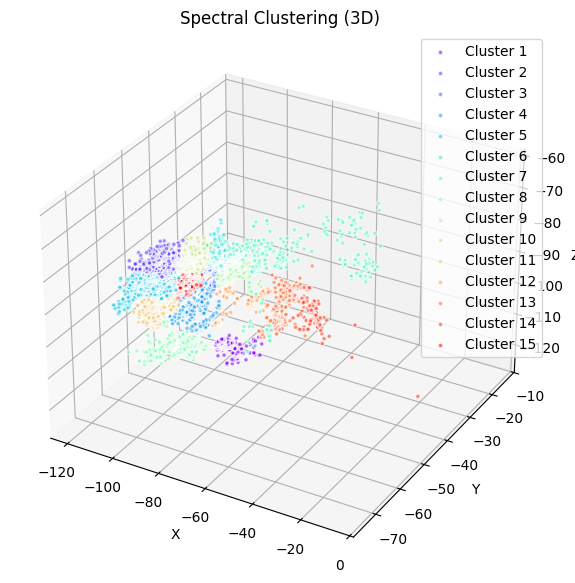

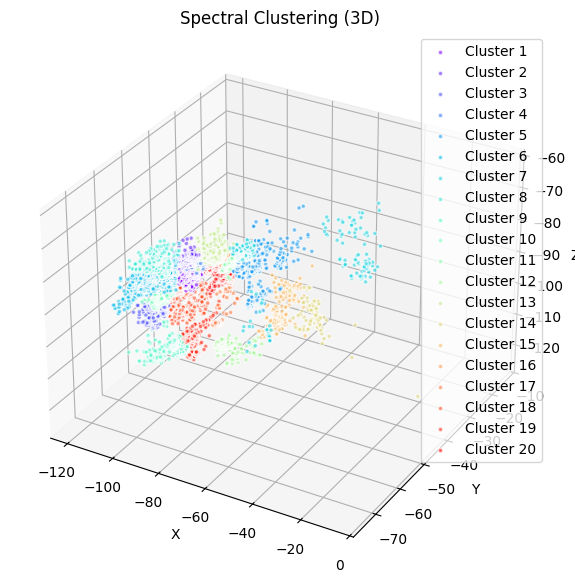

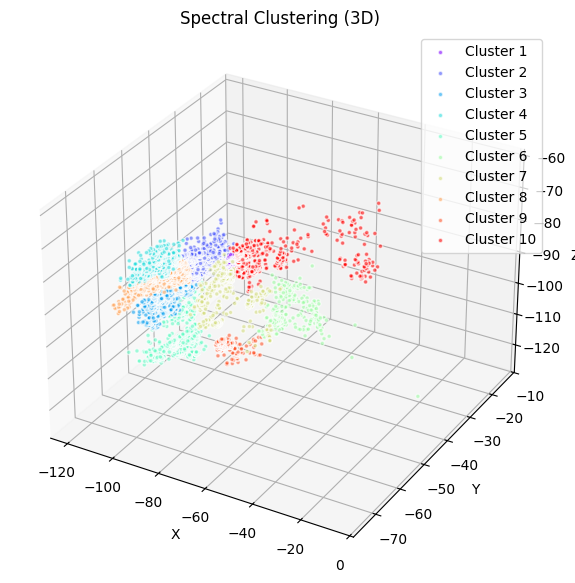

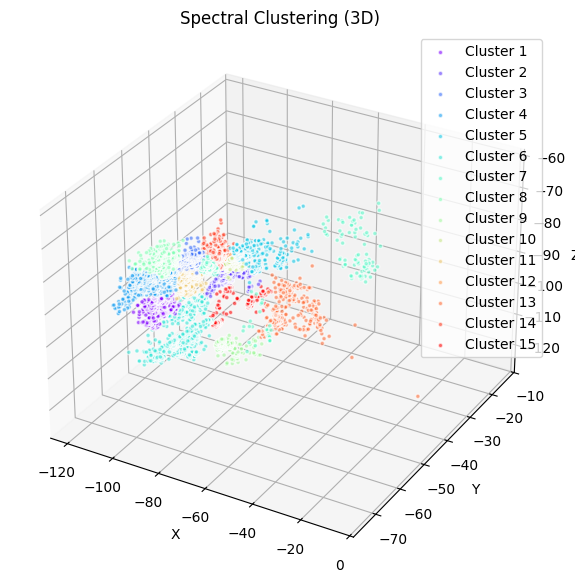

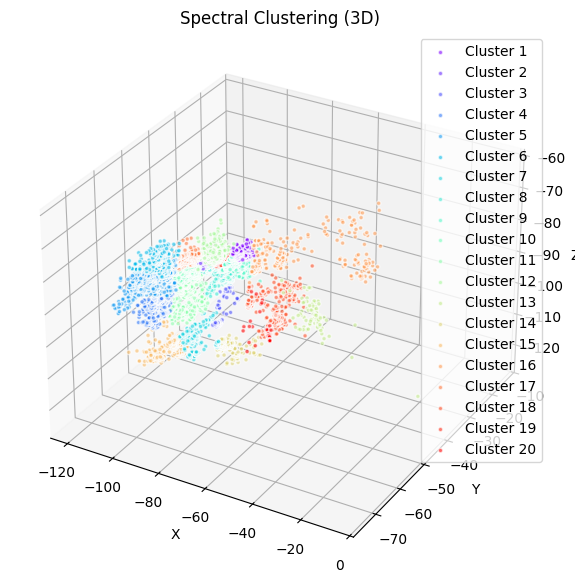

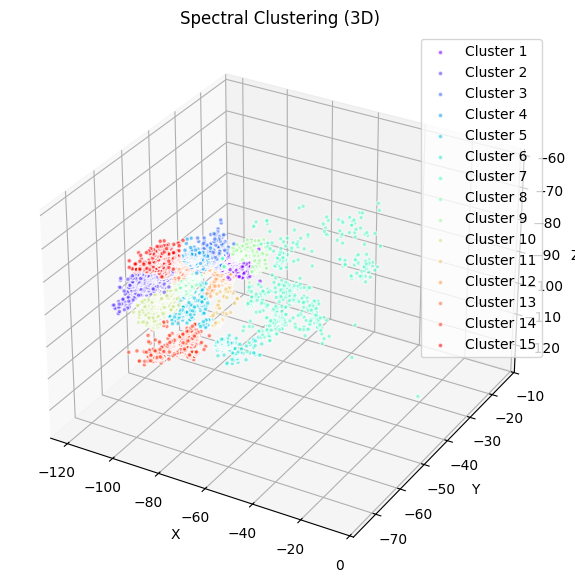

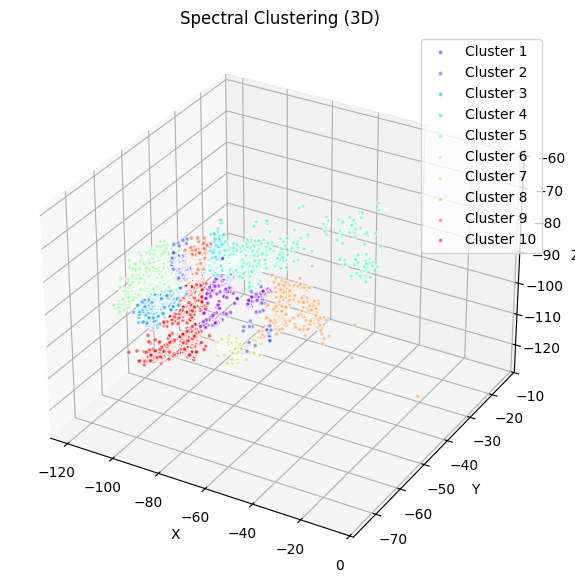

In [80]:
# k chosen of order log(n) (as suggested by the asymptotic connectivity results (luxburg2007))
# normalized graph laplacian (especially "rw") is best (luxburg2007)
clusters_k10_kvect20_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=10, laplacian_type="rw_norm", k_vect = 20,  plot=True)
clusters_k10_kvect10_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=10, laplacian_type="rw_norm", k_vect = 10,  plot=True)
clusters_k10_kvect15_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=10, laplacian_type="rw_norm", k_vect = 15,  plot=True)

clusters_k9_kvect20_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=9, laplacian_type="rw_norm", k_vect = 20,  plot=True)
clusters_k9_kvect10_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=9, laplacian_type="rw_norm", k_vect = 10,  plot=True)
clusters_k9_kvect15_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=9, laplacian_type="rw_norm", k_vect = 15,  plot=True)

clusters_k8_kvect20_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=8, laplacian_type="rw_norm", k_vect = 20,  plot=True)
clusters_k8_kvect15_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=8, laplacian_type="rw_norm", k_vect = 15,  plot=True)
clusters_k8_kvect10_ = spectral_clustering(X, graph_type="knn", sigma=None, epsilon=None, k=8, laplacian_type="rw_norm", k_vect = 10,  plot=True)
